<a href="https://colab.research.google.com/github/haneenbadr/Brain-Tumor-binaryClassification/blob/main/BrainTumar_BinaryClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [2]:
!kaggle datasets download -d murtozalikhon/brain-tumor-multimodal-image-ct-and-mri

Dataset URL: https://www.kaggle.com/datasets/murtozalikhon/brain-tumor-multimodal-image-ct-and-mri
License(s): CC-BY-NC-SA-4.0
 99% 356M/361M [00:01<00:00, 187MB/s]
100% 361M/361M [00:01<00:00, 224MB/s]


In [3]:
from zipfile import ZipFile
file_name = "/content/brain-tumor-multimodal-image-ct-and-mri.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [22]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

# **Data Spliting**

In [33]:
import os
import shutil
import random


dataset_path = "/content/Dataset/Brain Tumor CT scan Images"
classes = ['Healthy', 'Tumor']


train_dir = os.path.join(dataset_path, 'train')
val_dir = os.path.join(dataset_path, 'val')
test_dir = os.path.join(dataset_path, 'test')


for dir_path in [train_dir, val_dir, test_dir]:
    for cls in classes:
        os.makedirs(os.path.join(dir_path, cls), exist_ok=True)


for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    images = os.listdir(class_path)
    random.shuffle(images)

    train_split = int(0.7 * len(images))
    val_split = int(0.9 * len(images))

    train_images = images[:train_split]
    val_images = images[train_split:val_split]
    test_images = images[val_split:]

    for img in train_images:
        shutil.move(os.path.join(class_path, img), os.path.join(train_dir, cls, img))

    for img in val_images:
        shutil.move(os.path.join(class_path, img), os.path.join(val_dir, cls, img))

    for img in test_images:
        shutil.move(os.path.join(class_path, img), os.path.join(test_dir, cls, img))


# **Data Preprocessing**

In [36]:
train_data =ImageDataGenerator(rescale=1./255).flow_from_directory(
    os.path.join(dataset_path, 'train'),
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

val_data = ImageDataGenerator(rescale=1./255).flow_from_directory(
    os.path.join(dataset_path, 'val'),
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

test_data = ImageDataGenerator(rescale=1./255).flow_from_directory(
    os.path.join(dataset_path, 'test'),
     target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)




Found 3232 images belonging to 2 classes.
Found 924 images belonging to 2 classes.
Found 462 images belonging to 2 classes.


# **Build Model and Training**

In [56]:
#Custom CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)), # Change input_shape to (128, 128, 3)
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# 6. Early Stopping
# early_stopping = EarlyStopping(
#     monitor='val_loss',
#     patience=3,
#     restore_best_weights=True
# )

# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    #callbacks=[early_stopping]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - accuracy: 0.7323 - loss: 0.5304 - val_accuracy: 0.8203 - val_loss: 0.4343
Epoch 2/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 15s 100ms/step - accuracy: 0.8408 - loss: 0.3594 - val_accuracy: 0.8680 - val_loss: 0.3454
Epoch 3/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.8648 - loss: 0.3026 - val_accuracy: 0.8788 - val_loss: 0.2956
Epoch 4/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - accuracy: 0.8904 - loss: 0.2418 - val_accuracy: 0.8939 - val_loss: 0.2623
Epoch 5/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 21s 110ms/step - accuracy: 0.8977 - loss: 0.2386 - val_accuracy: 0.9037 - val_loss: 0.2402
Epoch 6/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step - accuracy: 0.9169 - loss: 0.2164 - val_accuracy: 0.9058 - val_loss: 0.2353
Epoch 7/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - accuracy: 0.9161 - loss: 0.2011 - val_accuracy: 0.9069 - val_loss: 0.2192
Epoch 8/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 21s 110ms/step - accuracy: 0.9217 -

# **Test Accuracy**

In [57]:
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.2f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.9861 - loss: 0.0469
Test Accuracy: 0.97


# **Classification Report**

In [58]:
y_true = test_data.classes
y_pred = (model.predict(test_data) > 0.5).astype("int32")
print(classification_report(y_true, y_pred, target_names=list(test_data.class_indices.keys())))

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step
              precision    recall  f1-score   support

     Healthy       0.96      0.99      0.97       230
       Tumor       0.99      0.96      0.97       232

    accuracy                           0.97       462
   macro avg       0.97      0.97      0.97       462
weighted avg       0.97      0.97      0.97       462



# **Graphical illustration**

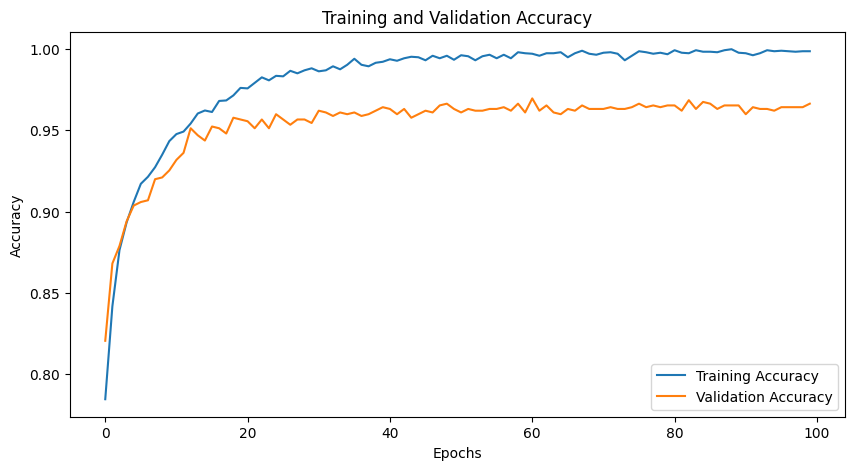

In [59]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

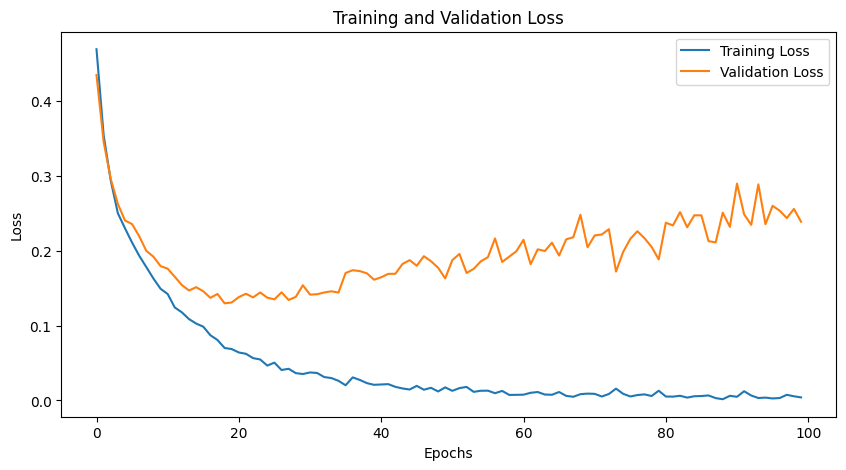

In [61]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **Confusion Matrix**

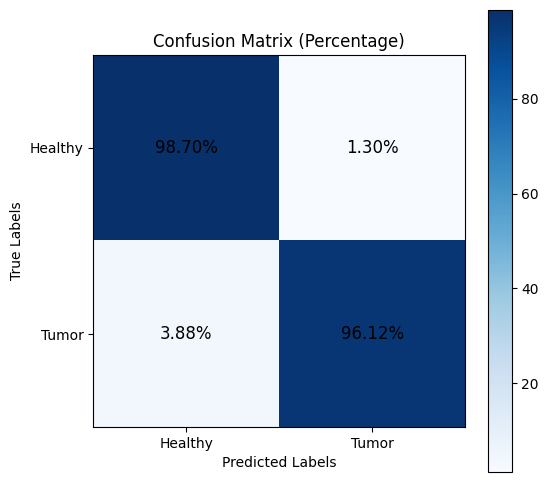

In [63]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


cm = confusion_matrix(y_true, y_pred)


cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6, 6))
plt.imshow(cm_percentage, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix (Percentage)')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks([0, 1], test_data.class_indices.keys())
plt.yticks([0, 1], test_data.class_indices.keys())


for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f'{cm_percentage[i, j]:.2f}%',
                 ha='center', va='center', color='black', fontsize=12)

plt.show()




# **Check Model**

In [65]:
# 9. Predicting an external image
def predict_external_image(image_path):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Could not read the image. Check the file path.")
        return
    # Resize and normalize the image
    image = cv2.resize(image, (128, 128))
    image = image / 255.0
    # Add batch dimension
    image = np.expand_dims(image, axis=0)
    # Predict
    prediction = model.predict(image)
    class_label = "Tumor" if prediction > 0.5 else "Healthy"
    print(f"Prediction: {class_label} (Confidence: {prediction[0][0]:.2f})")
    return class_label

# Example usage
external_image_path = "/content/CT-scan-image-of-brain-tumor.png"  # Update with the path to your image
predict_external_image(external_image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step
Prediction: Tumor (Confidence: 1.00)


'Tumor'

In [71]:
# 9. Predicting an external image
def predict_external_image(image_path):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Could not read the image. Check the file path.")
        return
    # Resize and normalize the image
    image = cv2.resize(image, (128, 128))
    image = image / 255.0
    # Add batch dimension
    image = np.expand_dims(image, axis=0)
    # Predict
    prediction = model.predict(image)
    class_label = "Tumor" if prediction > 0.5 else "Healthy"
    print(f"Prediction: {class_label} (Confidence: {prediction[0][0]:.2f})")
    return class_label

# Example usage
external_image_path = "/content/CT-scan-image-of-brain-healthy.jpg"  # Update with the path to your image
predict_external_image(external_image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction: Healthy (Confidence: 0.00)


'Healthy'